In [1]:
import torch
from torch import nn
import torchvision
import numpy as np
from pathlib import Path
import requests
import zipfile

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import shutil
data_path = Path('data')
image_path = data_path / 'PKLot'


if (image_path.is_dir()):
  shutil.rmtree(data_path)


image_path.mkdir(parents = True, 
                  exist_ok = True)
request = requests.get('https://github.com/2020uce0047/Parking-Space-Detection/raw/main/Dataset/dataset.zip')
f = open(data_path / 'pk_lot.zip', 'wb')
f.write(request.content)


zip_ref = zipfile.ZipFile(data_path / 'pk_lot.zip', 'r') 
zip_ref.extractall(image_path)
image_path = image_path / 'dataset'

In [4]:
## Transforming the data

#Import the libraries
from torchvision import transforms
import torchvision

#stack all the transforms to be done on the images
data_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),

    transforms.RandomHorizontalFlip(p = 0.5),

    transforms.ToTensor()
])

In [5]:
#Import the dataloader library
from torch.utils.data import DataLoader
from torchvision import datasets


#Turn the Image folder into a pytorch dataset which can used for training 
train_data = datasets.ImageFolder(root='data/PKLot/dataset/train',
                                  transform=data_transform)
test_data = datasets.ImageFolder(root = 'data/PKLot/dataset/test',
                                 transform = data_transform)


#Create train and test data loaders
train_dataloader = DataLoader(train_data,
                              batch_size=1, 
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                              batch_size=1)

In [6]:
class_names = train_data.classes
class_names

['Empty', 'Occupied']

In [7]:
x_sam, y_sam = next(iter(train_dataloader))
x_sam.shape

torch.Size([1, 3, 64, 64])

Number of samples should not be more than 15, you bastard!


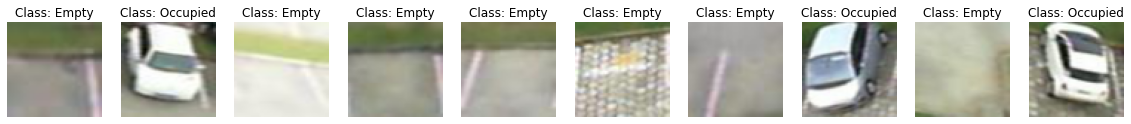

In [8]:
import matplotlib.pyplot as plt
import random
def display_random_images(dataset : list,
                          classes : list = class_names,
                          n_samples : int = 1):
  # torch.manual_seed(42)
  plt.figure(figsize = (20, 16))

  if(n_samples>12):
    n_samples = 10
    print('Number of samples should not be more than 15, you bastard!')
  img_sample = random.sample(list(train_data), k = n_samples)
  for idx in range(len(img_sample)):
    img = img_sample[idx][0].permute(1, 2, 0)
    label = img_sample[idx][1]
    plt.subplot(1, n_samples, idx+1)
    plt.imshow(img)
    plt.axis(False)
    title = f'Class: {classes[label]}'
    plt.title(title)
  plt.show()

display_random_images(dataset = train_data,
                       classes = class_names,
                       n_samples = 20)

In [9]:
from PIL import Image
def plot_transformed_images(image_list : list,
                            transform : torchvision.transforms,
                            n_samples : int = 3):
  random_img_list = random.sample(image_list, k = n_samples)
  # plt.figure(figsize = (9, 20))
  for idx, path in enumerate(random_img_list):

    fig, ax = plt.subplots(1, 2)
    ## Original Image
    img_arr = np.array(Image.open(path))
    label = path.parent.stem
    ax[0].imshow(img_arr)
    ax[0].set_title(f'Original \nShape: {img_arr.shape}')
    ax[0].axis(False)


    ## Transformed Image
    transformed_img = transform(Image.open(path))
    ax[1].imshow(transformed_img.permute(1, 2, 0))
    ax[1].set_title(f'Tranfomed \nShape:{transformed_img.shape}')
    ax[1].axis(False)

    fig.suptitle(f"Class: {path.parent.stem}", fontsize=16)
    # plt.axis(False)

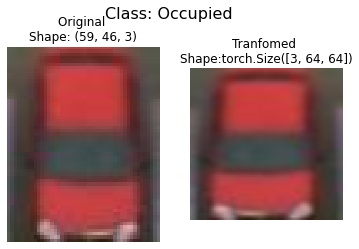

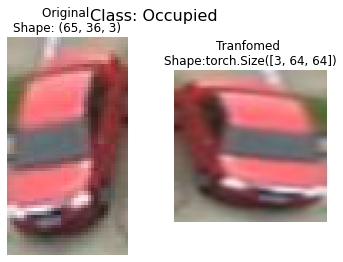

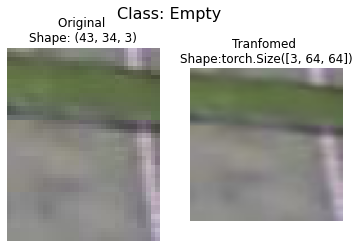

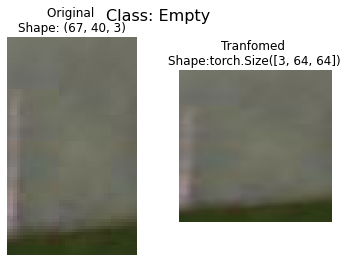

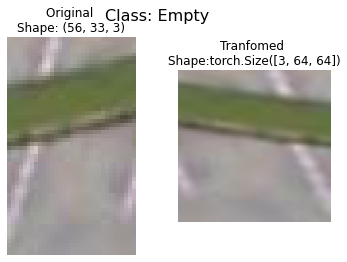

In [10]:
import numpy as np
# Get image paths for every image
image_path_list = list(image_path.glob('*/*/*.jpg'))
list(image_path_list)[:5]
plot_transformed_images(image_list = image_path_list,
                        transform = data_transform,
                        n_samples = 5)

In [11]:
def train_step(model : nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               accuracy_fn,
               device : torch.device = device):
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(data_loader):
    #Move the data to the device
    X, y = X.to(device), y.to(device)

    # Make the prediction
    y_pred = model(X)

    #Calculate the loss
    loss = loss_fn(y_pred, y)

    #Find the accuracy
    train_acc += accuracy_fn(y_pred = y_pred.argmax(dim = 1), y_true = y)

    #Add the loss to the training loss
    train_loss += loss

    #Initialize the optmiizer to have zero gradient
    optimizer.zero_grad()


    #Backward propagation
    #1. Find the partial derivatives of loss wrt weights adn bias
    loss.backward()

    #2. Update the weights
    optimizer.step()

    # if(batch%2==0):
    #   print(f'After {batch}: Train Loss - {train_loss:.4f} | Train Accuracy - {train_acc:.2f}')

  train_loss /= len(data_loader)
  train_acc /= 0.01*len(data_loader)
  print(f'Train Loss - {train_loss:.4f} | Train Accuracy - {train_acc:.2f}')

def test_step(model : nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              accuracy_fn,
              device : torch.device = device):
  test_loss, test_acc = 0, 0
  for X, y in data_loader:
    #Move the data to the device
    X, y = X.to(device), y.to(device)

    # Make the prediction
    y_pred = model(X)

    #Calculate the loss
    loss = loss_fn(y_pred, y)

    # #Logits to probs
    # y_pred = torch.sigmoid(y_pred)

    #Find the accuracy
    test_acc += accuracy_fn(y_pred = y_pred.argmax(dim = 1), y_true = y)

    #Add the loss to the testing loss
    test_loss += loss


  test_loss /= len(data_loader)
  test_acc /= 0.01*len(data_loader)
  print(f'Test Loss - {test_loss:.4f} | Test Accuracy - {test_acc:.2f}')

In [12]:
import timeit
def time_taken_by_model(start_time : float, end_time : float):
  diff_time = end_time - start_time
  return diff_time

In [13]:
def accuracy_fn(y_true, y_pred):
  n_correct = torch.eq(y_true, y_pred).sum().item()
  acc = n_correct/len(y_true)
  return acc

In [14]:
class PKLot_modelV1(nn.Module):
  def __init__(self, input_channels : int, hidden_units : int, output_channels : int):
    super().__init__()
    self.cnn_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels = input_channels,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                         stride=2)
    )
    self.cnn_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 2560,
                  out_features = output_channels)
    )

  def forward(self, x):
    x = self.cnn_block_1(x)
    x = self.cnn_block_2(x)
    x = self.classifier(x)
    return x
model1 = PKLot_modelV1(input_channels = 3, hidden_units = 10, output_channels = 2).to(device)

In [15]:
model1

PKLot_modelV1(
  (cnn_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=2, bias=True)
  )
)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model1.parameters(), lr = 0.01)

In [18]:
EPOCHS = 3
start_time_on_cpu = timeit.default_timer()
for epoch in range(EPOCHS):
  print(f'Epoch: {epoch+1}\n--------')
  model1.train()
  train_step(model1, 
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device=device)
  model1.eval()
  with torch.inference_mode():
    test_step(model1, 
              data_loader = test_dataloader,
              loss_fn = loss_fn,
              accuracy_fn = accuracy_fn,
              device=device)
end_time_on_cpu = timeit.default_timer()
time_on_cpu = time_taken_by_model(start_time_on_cpu, end_time_on_cpu)

Epoch: 1
--------
Train Loss - 0.4481 | Train Accuracy - 78.29
Test Loss - 0.6782 | Test Accuracy - 61.40
Epoch: 2
--------
Train Loss - 0.1787 | Train Accuracy - 93.22
Test Loss - 0.1153 | Test Accuracy - 95.53
Epoch: 3
--------
Train Loss - 0.1224 | Train Accuracy - 95.78
Test Loss - 0.0927 | Test Accuracy - 97.67


In [19]:
class_names = train_data.classes
class_names

['Empty', 'Occupied']

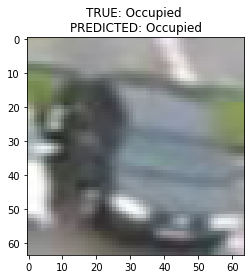

In [23]:
model1.eval()
img, y_true = random.choice(test_data)
img = img.to(device)
# X = data_transform(Image.open(img)).to(device)
# y_true = img.parent.stem
# X.shape
with torch.inference_mode():
    # Make the prediction
    y_pred = model1(img.unsqueeze(dim = 0))
plt.imshow(img.cpu().permute(1, 2, 0))
plt.title(f'TRUE: {class_names[y_true]} \nPREDICTED: {class_names[y_pred.argmax(dim = 1)[0]]}')
plt.show()

In [21]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True )

# Create model save path
MODEL_NAME = "PKLot.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model1.state_dict(), 
           f=MODEL_SAVE_PATH)

Saving model to: models/PKLot.pth
